In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


# Wczytanie danych
df = pd.read_csv('../data/ObesityDataSet.csv')

# --- Przygotowanie danych dla regresji logistycznej ---
X = df.drop(columns=['NObeyesdad'])  # Target to 'NObeyesdad'
y = df['NObeyesdad']

# One-hot encoding + standaryzacja
X_encoded = pd.get_dummies(X)
X_encoded = X_encoded.astype(np.float64)

scaler_s = StandardScaler()
X_scaled = scaler_s.fit_transform(X_encoded)
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

# Label encoding targetu
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Podział
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Zadanie 1 - Cross-validation

In [7]:
def logistic_gradient_descent(X, y, alpha=0.01, epochs=1000, batch_size=32, num_classes=None):
    m, n = X.shape
    if num_classes is None:
        num_classes = len(np.unique(y))
    Y = np.eye(num_classes)[y]  # One-hot

    theta = np.zeros((n, num_classes))

    for epoch in range(epochs):
        indices = np.random.permutation(m)
        for i in range(0, m, batch_size):
            idx = indices[i:i+batch_size]
            X_batch = X[idx]
            Y_batch = Y[idx]
            logits = X_batch @ theta
            probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
            grad = X_batch.T @ (probs - Y_batch) / batch_size
            theta -= alpha * grad
    return theta

def predict_multiclass(X, theta):
    logits = X @ theta
    return np.argmax(logits, axis=1)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def cross_validate_logistic_regression(X, y, folds=3, **kwargs):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, val_idx in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        theta = logistic_gradient_descent(X_train_fold, y_train_fold, **kwargs)
        y_pred = predict_multiclass(X_val_fold, theta)
        acc = accuracy(y_val_fold, y_pred)
        accuracies.append(acc)

    return np.mean(accuracies), np.std(accuracies)

# 1) Bez walidacji krzyżowej
theta = logistic_gradient_descent(
    X_train, y_train,
    alpha=0.01, epochs=1000, batch_size=32
)

y_train_pred = predict_multiclass(X_train, theta)
y_val_pred   = predict_multiclass(X_val, theta)
y_test_pred  = predict_multiclass(X_test, theta)

print("=== Bez walidacji krzyżowej ===")
print(f"Train accuracy: {accuracy(y_train, y_train_pred):.4f}")
print(f"Val   accuracy: {accuracy(y_val, y_val_pred):.4f}")
print(f"Test  accuracy: {accuracy(y_test, y_test_pred):.4f}")

# 2) Z 3-krotną walidacją krzyżową
print("\n=== Z 3-krotną walidacją krzyżową ===")
datasets = {
    "Train":      (X_train, y_train),
    "Validation": (X_val, y_val),
    "Test":       (X_test, y_test)
}

for name, (X_part, y_part) in datasets.items():
    mean_acc, std_acc = cross_validate_logistic_regression(
        X_part, y_part,
        folds=3,
        alpha=0.01, epochs=1000, batch_size=32
    )
    print(f"{name:>10}: {mean_acc:.4f} ± {std_acc:.4f}")


=== Bez walidacji krzyżowej ===
Train accuracy: 0.8468
Val   accuracy: 0.8128
Test  accuracy: 0.8487

=== Z 3-krotną walidacją krzyżową ===
     Train: 0.7954 ± 0.0156
Validation: 0.6872 ± 0.0381
      Test: 0.7092 ± 0.0058


# Zadanie 2 -  PolynomialFeatures

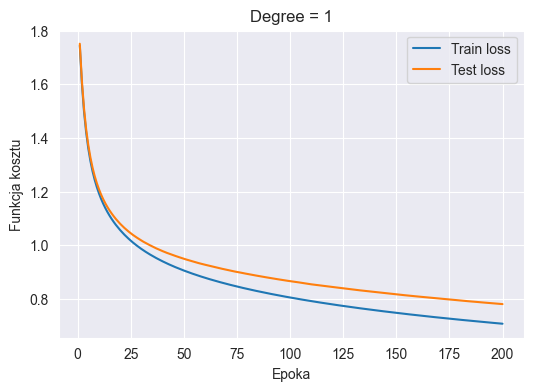

Degree = 1
Train Accuracy: 0.7622
Validation Accuracy: 0.7393
Test Accuracy: 0.7541
----------------------------------------


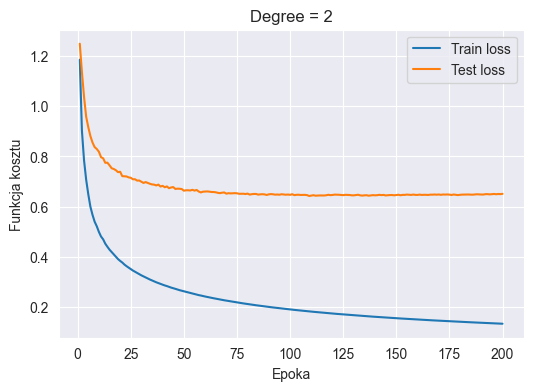

Degree = 2
Train Accuracy: 0.9724
Validation Accuracy: 0.8673
Test Accuracy: 0.8629
----------------------------------------


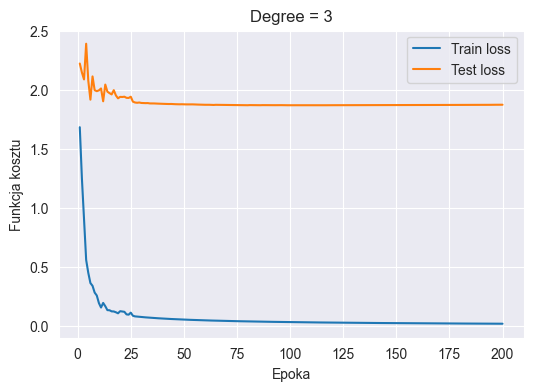

Degree = 3
Train Accuracy: 0.9992
Validation Accuracy: 0.8578
Test Accuracy: 0.8771
----------------------------------------


In [41]:
# -*- coding: utf-8 -*-
"""
Jupyter Notebook cell: Analiza zbieżności i over/under-fitting
dla własnej implementacji regresji logistycznej z SGD oraz cech wielomianowych.
"""

from sklearn.preprocessing import PolynomialFeatures

# --- Funkcja obliczająca koszt (cross-entropy) ---
def compute_cost(X, Y, theta):
    """
    X: (m, n)
    Y: one-hot (m, k)
    theta: (n, k)
    zwraca średni cross-entropy
    """
    m = X.shape[0]
    logits = X @ theta
    exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exps / np.sum(exps, axis=1, keepdims=True)
    ce = -np.sum(Y * np.log(probs + 1e-15)) / m
    return ce

# --- Własna implementacja SGD z zapisem historii kosztu ---
def logistic_gradient_descent_trace(
    X, y,
    X_val=None, y_val=None,
    alpha=0.01, epochs=200, batch_size=32,
    num_classes=None
):
    m, n = X.shape
    if num_classes is None:
        num_classes = len(np.unique(y))
    Y  = np.eye(num_classes)[y]
    Yv = np.eye(num_classes)[y_val] if (X_val is not None and y_val is not None) else None

    theta = np.zeros((n, num_classes))
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs + 1):
        perm = np.random.permutation(m)
        for i in range(0, m, batch_size):
            idx = perm[i:i + batch_size]
            Xb, Yb = X[idx], Y[idx]
            logits = Xb @ theta
            exps   = np.exp(logits - np.max(logits, axis=1, keepdims=True))
            probs  = exps / np.sum(exps, axis=1, keepdims=True)
            grad   = Xb.T @ (probs - Yb) / batch_size
            theta -= alpha * grad

        # Zapisz koszty po epoce
        history['train_loss'].append(compute_cost(X, Y, theta))
        if X_val is not None and Yv is not None:
            history['val_loss'].append(compute_cost(X_val, Yv, theta))

    return theta, history

# --- Funkcja rysująca konwergencję ---
def plot_convergence(history, title="Convergence"):
    epochs = np.arange(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history['train_loss'], label='Train loss')
    if 'val_loss' in history and len(history['val_loss']) == len(history['train_loss']):
        plt.plot(epochs, history['val_loss'], label='Test loss')
    plt.xlabel('Epoka')
    plt.ylabel('Funkcja kosztu')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def predict(X, theta):
    logits = X @ theta
    return np.argmax(logits, axis=1)

def compute_accuracy(X, y_true, theta):
    y_pred = predict(X, theta)
    return np.mean(y_pred == y_true)

# --- Przykład użycia ---
for degree in [1, 2, 3]:
    poly = PolynomialFeatures(degree, include_bias=False)
    X_train_p = poly.fit_transform(X_train)
    X_val_p   = poly.transform(X_val)
    X_test_p  = poly.transform(X_test)

    theta_p, hist_p = logistic_gradient_descent_trace(
        X_train_p, y_train,
        X_val=X_val_p, y_val=y_val,
        alpha=0.01,
        epochs=200,
        batch_size=32
    )

    plot_convergence(hist_p, title=f"Degree = {degree}")

    acc_train = compute_accuracy(X_train_p, y_train, theta_p)
    acc_val = compute_accuracy(X_val_p, y_val, theta_p)
    acc_test = compute_accuracy(X_test_p, y_test, theta_p)

    print(f"Degree = {degree}")
    print(f"Train Accuracy: {acc_train:.4f}")
    print(f"Validation Accuracy: {acc_val:.4f}")
    print(f"Test Accuracy: {acc_test:.4f}")
    print("-" * 40)


# Zadanie 3 - Regularyzacja L1 i L2

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# --- Wczytanie i przygotowanie danych ---
df = pd.read_csv('../data/ObesityDataSet.csv')
X = df.drop(columns=['NObeyesdad'])
y = df['NObeyesdad']
X_encoded = pd.get_dummies(X).astype(np.float64)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
# dodaj bias
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_encoded, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

feature_names = ['bias'] + list(X_encoded.columns)
class_names = list(label_encoder.classes_)

# --- Funkcja uczenia z regularyzacją ---
def logistic_gradient_descent(X, y, alpha=0.01, epochs=1000, batch_size=32,
                             num_classes=None, reg_type=None, reg_lambda=0.0):
    m, n = X.shape
    if num_classes is None:
        num_classes = len(np.unique(y))
    Y = np.eye(num_classes)[y]
    theta = np.zeros((n, num_classes))

    for _ in range(epochs):
        idxs = np.random.permutation(m)
        for i in range(0, m, batch_size):
            batch = idxs[i:i+batch_size]
            Xb, Yb = X[batch], Y[batch]
            logits = Xb @ theta
            logits -= np.max(logits, axis=1, keepdims=True)
            probs = np.exp(logits)
            probs /= probs.sum(axis=1, keepdims=True)

            grad = Xb.T @ (probs - Yb) / batch_size

            # regularyzacja (bez biasu)
            if reg_type == 'l2':
                grad[1:] += (reg_lambda / batch_size) * theta[1:]
            elif reg_type == 'l1':
                grad[1:] += (reg_lambda / batch_size) * np.sign(theta[1:])

            theta -= alpha * grad

    return theta

def predict_multiclass(X, theta):
    return np.argmax(X @ theta, axis=1)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# --- Trenujemy i wypisujemy wszystko raz ---
for model_name, params in [
    ('Brak regularyzacji', {'reg_type': None, 'reg_lambda': 0.0}),
    ('Ridge (L2)',        {'reg_type': 'l2', 'reg_lambda': 1.0}),
    ('Lasso (L1)',        {'reg_type': 'l1', 'reg_lambda': 1.0})
]:
    print(f"\n=== {model_name} ===")
    theta = logistic_gradient_descent(
        X_train, y_train,
        alpha=0.01, epochs=1000, batch_size=32,
        num_classes=len(class_names),
        **params
    )

    # 1) Wyświetlenie wag jako DataFrame (tylko raz)
    df_w = pd.DataFrame(theta, index=feature_names, columns=class_names)
    print("\nWagi cech:\n", df_w, "\n")

    # 2) Dokładności
    for split_name, Xd, yd in [
        ('Treningowy',     X_train, y_train),
        ('Walidacyjny',    X_val,   y_val),
        ('Testowy',        X_test,  y_test)
    ]:
        y_pred = predict_multiclass(Xd, theta)
        print(f"{split_name} accuracy: {accuracy(yd, y_pred):.4f}")



=== Brak regularyzacji ===

Wagi cech:
                                     Insufficient_Weight  Normal_Weight  \
bias                                          -2.817574       0.389935   
Age                                           -0.934517      -0.258098   
Height                                         1.987658       0.794194   
Weight                                        -7.055480      -4.286368   
FCVC                                          -0.034037      -0.296838   
NCP                                            0.022094       0.012937   
CH2O                                           0.048548      -0.166728   
FAF                                            0.074161       0.279512   
TUE                                            0.166066       0.024434   
Gender_Female                                  0.153099      -0.181881   
Gender_Male                                   -0.153099       0.181881   
family_history_with_overweight_no              0.214858       0.203156 

# Zadanie 4 - balansowanie zbiorów - Oversampling i Undersampling

In [36]:
# -*- coding: utf-8 -*-
"""
Jupyter Notebook cell:
Zadanie 4 – balansowanie zbiorów i własna implementacja regresji logistycznej
"""

import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# --- Zakładamy już załadowane dane i podziały:
# X_train, y_train, X_val, y_val, X_test, y_test

# 1) Standaryzacja cech
scaler = StandardScaler().fit(X_train)
X_tr = scaler.transform(X_train)
X_va = scaler.transform(X_val)
X_te = scaler.transform(X_test)

# 2) Balansowanie zbioru treningowego
# 2a) Oversampling SMOTE
smote = SMOTE(random_state=42)
X_tr_smote, y_tr_smote = smote.fit_resample(X_tr, y_train)

# 2b) Undersampling losowy
rus = RandomUnderSampler(random_state=42)
X_tr_rus, y_tr_rus = rus.fit_resample(X_tr, y_train)

# 3) Rozszerzona definicja własnej implementacji regresji logistycznej
class CustomLogisticRegression:
    def __init__(self, alpha=0.01, epochs=1000, batch_size=32):
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size
        self.theta = None

    def fit(self, X, y):
        m, n = X.shape
        num_classes = len(np.unique(y))
        Y = np.eye(num_classes)[y]
        self.theta = np.zeros((n, num_classes))

        for epoch in range(self.epochs):
            perm = np.random.permutation(m)
            for i in range(0, m, self.batch_size):
                idx = perm[i:i+self.batch_size]
                Xb, Yb = X[idx], Y[idx]
                logits = Xb @ self.theta
                exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
                probs = exps / np.sum(exps, axis=1, keepdims=True)
                grad = Xb.T @ (probs - Yb) / len(idx)
                self.theta -= self.alpha * grad
        return self

    def predict(self, X):
        return np.argmax(X @ self.theta, axis=1)

# 4) Funkcja ewaluacji
def eval_and_report(name, y_true, y_pred):
    print(f"--- {name} ---")
    print(classification_report(y_true, y_pred, digits=4))

# 5) Trenowanie i ewaluacja własnego modelu na różnych zbiorach

datasets = {
    'Original': (X_tr, y_train),
    'SMOTE':    (X_tr_smote, y_tr_smote),
    'Under':    (X_tr_rus, y_tr_rus)
}

for ds_name, (X_train_ds, y_train_ds) in datasets.items():
    print(f"\n==================== {ds_name} ====================")

    # Inicjalizacja i trenowanie modelu
    model = CustomLogisticRegression(alpha=0.01, epochs=1000, batch_size=32)
    model.fit(X_train_ds, y_train_ds)

    # Ewaluacja na wszystkich zbiorach
    for split, (X_eval, y_eval) in [
        ('Train', (X_train_ds, y_train_ds)),
        ('Val', (X_va, y_val)),
        ('Test', (X_te, y_test))
    ]:
        y_pred = model.predict(X_eval)
        eval_and_report(f"Custom Model {ds_name} on {split}", y_eval, y_pred)


==================== Original ====================
--- Custom Model Original on Train ---
              precision    recall  f1-score   support

           0     0.6356    0.9036    0.7463       166
           1     0.6636    0.4303    0.5221       165
           2     0.8865    0.7664    0.8221       214
           3     0.8398    0.9719    0.9010       178
           4     0.9163    1.0000    0.9563       186
           5     0.7267    0.6573    0.6903       178
           6     0.7560    0.7095    0.7320       179

    accuracy                         0.7804      1266
   macro avg     0.7749    0.7770    0.7671      1266
weighted avg     0.7814    0.7804    0.7726      1266

--- Custom Model Original on Val ---
              precision    recall  f1-score   support

           0     0.6104    0.9592    0.7460        49
           1     0.8158    0.4627    0.5905        67
           2     0.8750    0.6885    0.7706        61
           3     0.8400    0.9844    0.9065        64
    

# Zadanie 5 - Optymalizacja hiperparametrów

In [38]:
# -*- coding: utf-8 -*-
"""
Jupyter Notebook cell:
5. Optymalizacja hiperparametrów – GridSearchCV dla LogisticRegression i DecisionTreeClassifier
   oraz ewaluacja na zbiorach treningowym, walidacyjnym i testowym
"""

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# --- 0) Skalowanie cech ---
scaler = StandardScaler().fit(X_train)
X_tr = scaler.transform(X_train)
X_va = scaler.transform(X_val)
X_te = scaler.transform(X_test)

# Połączymy train + val do strojenia, a test zostawimy na sam koniec
X_tune = np.vstack([X_tr, X_va])
y_tune = np.concatenate([y_train, y_val])

def evaluate_model(name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    """Funkcja pomocnicza do wypisywania classification_report na trzech zbiorach."""
    print(f"\n--- {name} ---")
    for split_name, X, y in [
        ("Train", X_train, y_train),
        ("Validation", X_val, y_val),
        ("Test", X_test, y_test)
    ]:
        y_pred = model.predict(X)
        print(f"\n{split_name} set:")
        print(classification_report(y, y_pred, digits=4))


# --- 1) GridSearch dla LogisticRegression ---
param_grid_lr = [
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1.0, 10.0]},
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1.0, 10.0], 'solver': ['saga']},
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1.0, 10.0], 'l1_ratio': [0.2, 0.5, 0.8], 'solver': ['saga']}
]

gs_lr = GridSearchCV(
    estimator=LogisticRegression(solver='saga', max_iter=2000),
    param_grid=param_grid_lr,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)
gs_lr.fit(X_tune, y_tune)

print("=== LogisticRegression ===")
print("Best params:", gs_lr.best_params_)
print("Best CV score:", gs_lr.best_score_)

best_lr = gs_lr.best_estimator_
evaluate_model(
    "LogisticRegression",
    best_lr,
    X_tr, y_train,
    X_va, y_val,
    X_te, y_test
)


# --- 2) GridSearch dla DecisionTreeClassifier ---
param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

gs_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)
gs_dt.fit(X_tune, y_tune)

print("=== DecisionTreeClassifier ===")
print("Best params:", gs_dt.best_params_)
print("Best CV score:", gs_dt.best_score_)

best_dt = gs_dt.best_estimator_
evaluate_model(
    "DecisionTreeClassifier",
    best_dt,
    X_tr, y_train,
    X_va, y_val,
    X_te, y_test
)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
=== LogisticRegression ===
Best params: {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}
Best CV score: 0.9219577799020561

--- LogisticRegression ---

Train set:
              precision    recall  f1-score   support

           0     0.9326    1.0000    0.9651       166
           1     0.9530    0.8606    0.9045       165
           2     0.9765    0.9720    0.9742       214
           3     0.9944    0.9888    0.9915       178
           4     1.0000    1.0000    1.0000       186
           5     0.8927    0.8876    0.8901       178
           6     0.8978    0.9330    0.9151       179

    accuracy                         0.9502      1266
   macro avg     0.9496    0.9488    0.9487      1266
weighted avg     0.9507    0.9502    0.9500      1266


Validation set:
              precision    recall  f1-score   support

           0     0.9412    0.9796    0.9600        49
           1     0.9683    0.9104    0.9385        67
 

# Zadanie 6 - Ensemble methods

In [40]:
# -*- coding: utf-8 -*-
"""
6. Ensemble methods – VotingClassifier and StackingClassifier
"""

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report

# Standaryzacja cech
scaler = StandardScaler().fit(X_train)
X_tr = scaler.transform(X_train)
X_va = scaler.transform(X_val)
X_te = scaler.transform(X_test)

# --- 1) Definicja bazowych klasyfikatorów ---
base_models = [
    ('lr',  LogisticRegression(solver='lbfgs', max_iter=1000)),
    ('dt',  DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('svc', SVC(kernel='rbf', probability=True, gamma='scale'))
]

# --- 2) VotingClassifier ---
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

# Trenujemy i ewaluujemy VotingClassifier
for name, clf in [('Voting Hard', voting_hard), ('Voting Soft', voting_soft)]:
    clf.fit(X_tr, y_train)
    print(f"\n=== {name} on Train ===")
    y_tr_pred = clf.predict(X_tr)
    print(classification_report(y_train, y_tr_pred, digits=4))

    print(f"=== {name} on Validation ===")
    y_va_pred = clf.predict(X_va)
    print(classification_report(y_val, y_va_pred, digits=4))

    print(f"=== {name} on Test ===")
    y_te_pred = clf.predict(X_te)
    print(classification_report(y_test, y_te_pred, digits=4))

# --- 3) StackingClassifier ---
stack = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(solver='lbfgs', max_iter=1000),
    cv=5,
    passthrough=False,
    n_jobs=-1
)

stack.fit(X_tr, y_train)
print("\n=== Stacking on Train ===")
y_tr_stack = stack.predict(X_tr)
print(classification_report(y_train, y_tr_stack, digits=4))

print("=== Stacking on Validation ===")
y_va_stack = stack.predict(X_va)
print(classification_report(y_val, y_va_stack, digits=4))

print("=== Stacking on Test ===")
y_te_stack = stack.predict(X_te)
print(classification_report(y_test, y_te_stack, digits=4))



=== Voting Hard on Train ===
              precision    recall  f1-score   support

           0     0.9368    0.9819    0.9588       166
           1     0.8889    0.8242    0.8553       165
           2     0.9111    0.9579    0.9339       214
           3     0.9722    0.9831    0.9777       178
           4     1.0000    0.9946    0.9973       186
           5     0.8639    0.8202    0.8415       178
           6     0.8444    0.8492    0.8468       179

    accuracy                         0.9179      1266
   macro avg     0.9168    0.9159    0.9159      1266
weighted avg     0.9172    0.9179    0.9171      1266

=== Voting Hard on Validation ===
              precision    recall  f1-score   support

           0     0.8727    0.9796    0.9231        49
           1     0.7656    0.7313    0.7481        67
           2     0.8966    0.8525    0.8739        61
           3     0.9130    0.9844    0.9474        64
           4     0.9714    1.0000    0.9855        68
           5  